In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
plt.style.use('sensitivity.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
G4Offset = -894.59

minR = 0.0
maxR = 627.0458
minZ = -767.883544921875 + 3.0 + G4Offset + 1581
maxZ = 513.116455078125 + G4Offset + 1581

with open('/gpfs/slac/staas/fs1/g/exo/exo_data8/exo_data/users/akojamil/chroma/sensitivity2020/20200528_sensitivity_lightmap_raw_data.npy', 'rb') as f:
    Radius = np.load(f)
    Height = np.load(f)
    Eff = np.load(f)
Height = Height + G4Offset + 1581

cut0 = np.where(Eff > 0.0)
Radius = Radius[cut0]
Height = Height[cut0]
Eff = Eff[cut0]

In [3]:
bins = 0.5

maxR = np.around(maxR, 1)
minZ = np.around(minZ, -1)
maxZ = np.around(maxZ, -1)

binR = np.linspace(0.0,maxR,int(maxR/float(bins)))
binZ = np.linspace(minZ,maxZ,int((maxZ-minZ)/float(bins)))

In [4]:
HistC, XEdges, YEdges =  np.histogram2d(x=Radius, y=Height, bins=(binR, binZ))
HistEff, XEdges, YEdges =  np.histogram2d(x=Radius, y=Height, weights=Eff, bins=(binR, binZ))

X, Y = np.meshgrid(XEdges, YEdges)

HistC[HistC==0] = 1.0 # prevent division by zero

Hist = (HistEff/HistC).T

# replace empty bin with average over adjacent 8 bins
Cut = np.where((X[:-1,:-1]<550) & (Y[:-1,:-1]<1150) & (Y[:-1,:-1]>0) & (Hist==0))
XCut = Cut[0]
YCut = Cut[1]
for x,y in zip(XCut,YCut):
    HistMean = np.mean([Hist[x+1,y], Hist[x-1,y], Hist[x,y+1], Hist[x,y-1], Hist[x+1,y+1], Hist[x-1,y-1], Hist[x+1,y-1], Hist[x-1,y+1]])
    Hist[x,y] = HistMean

Hist = gaussian_filter(Hist, sigma=1.0)

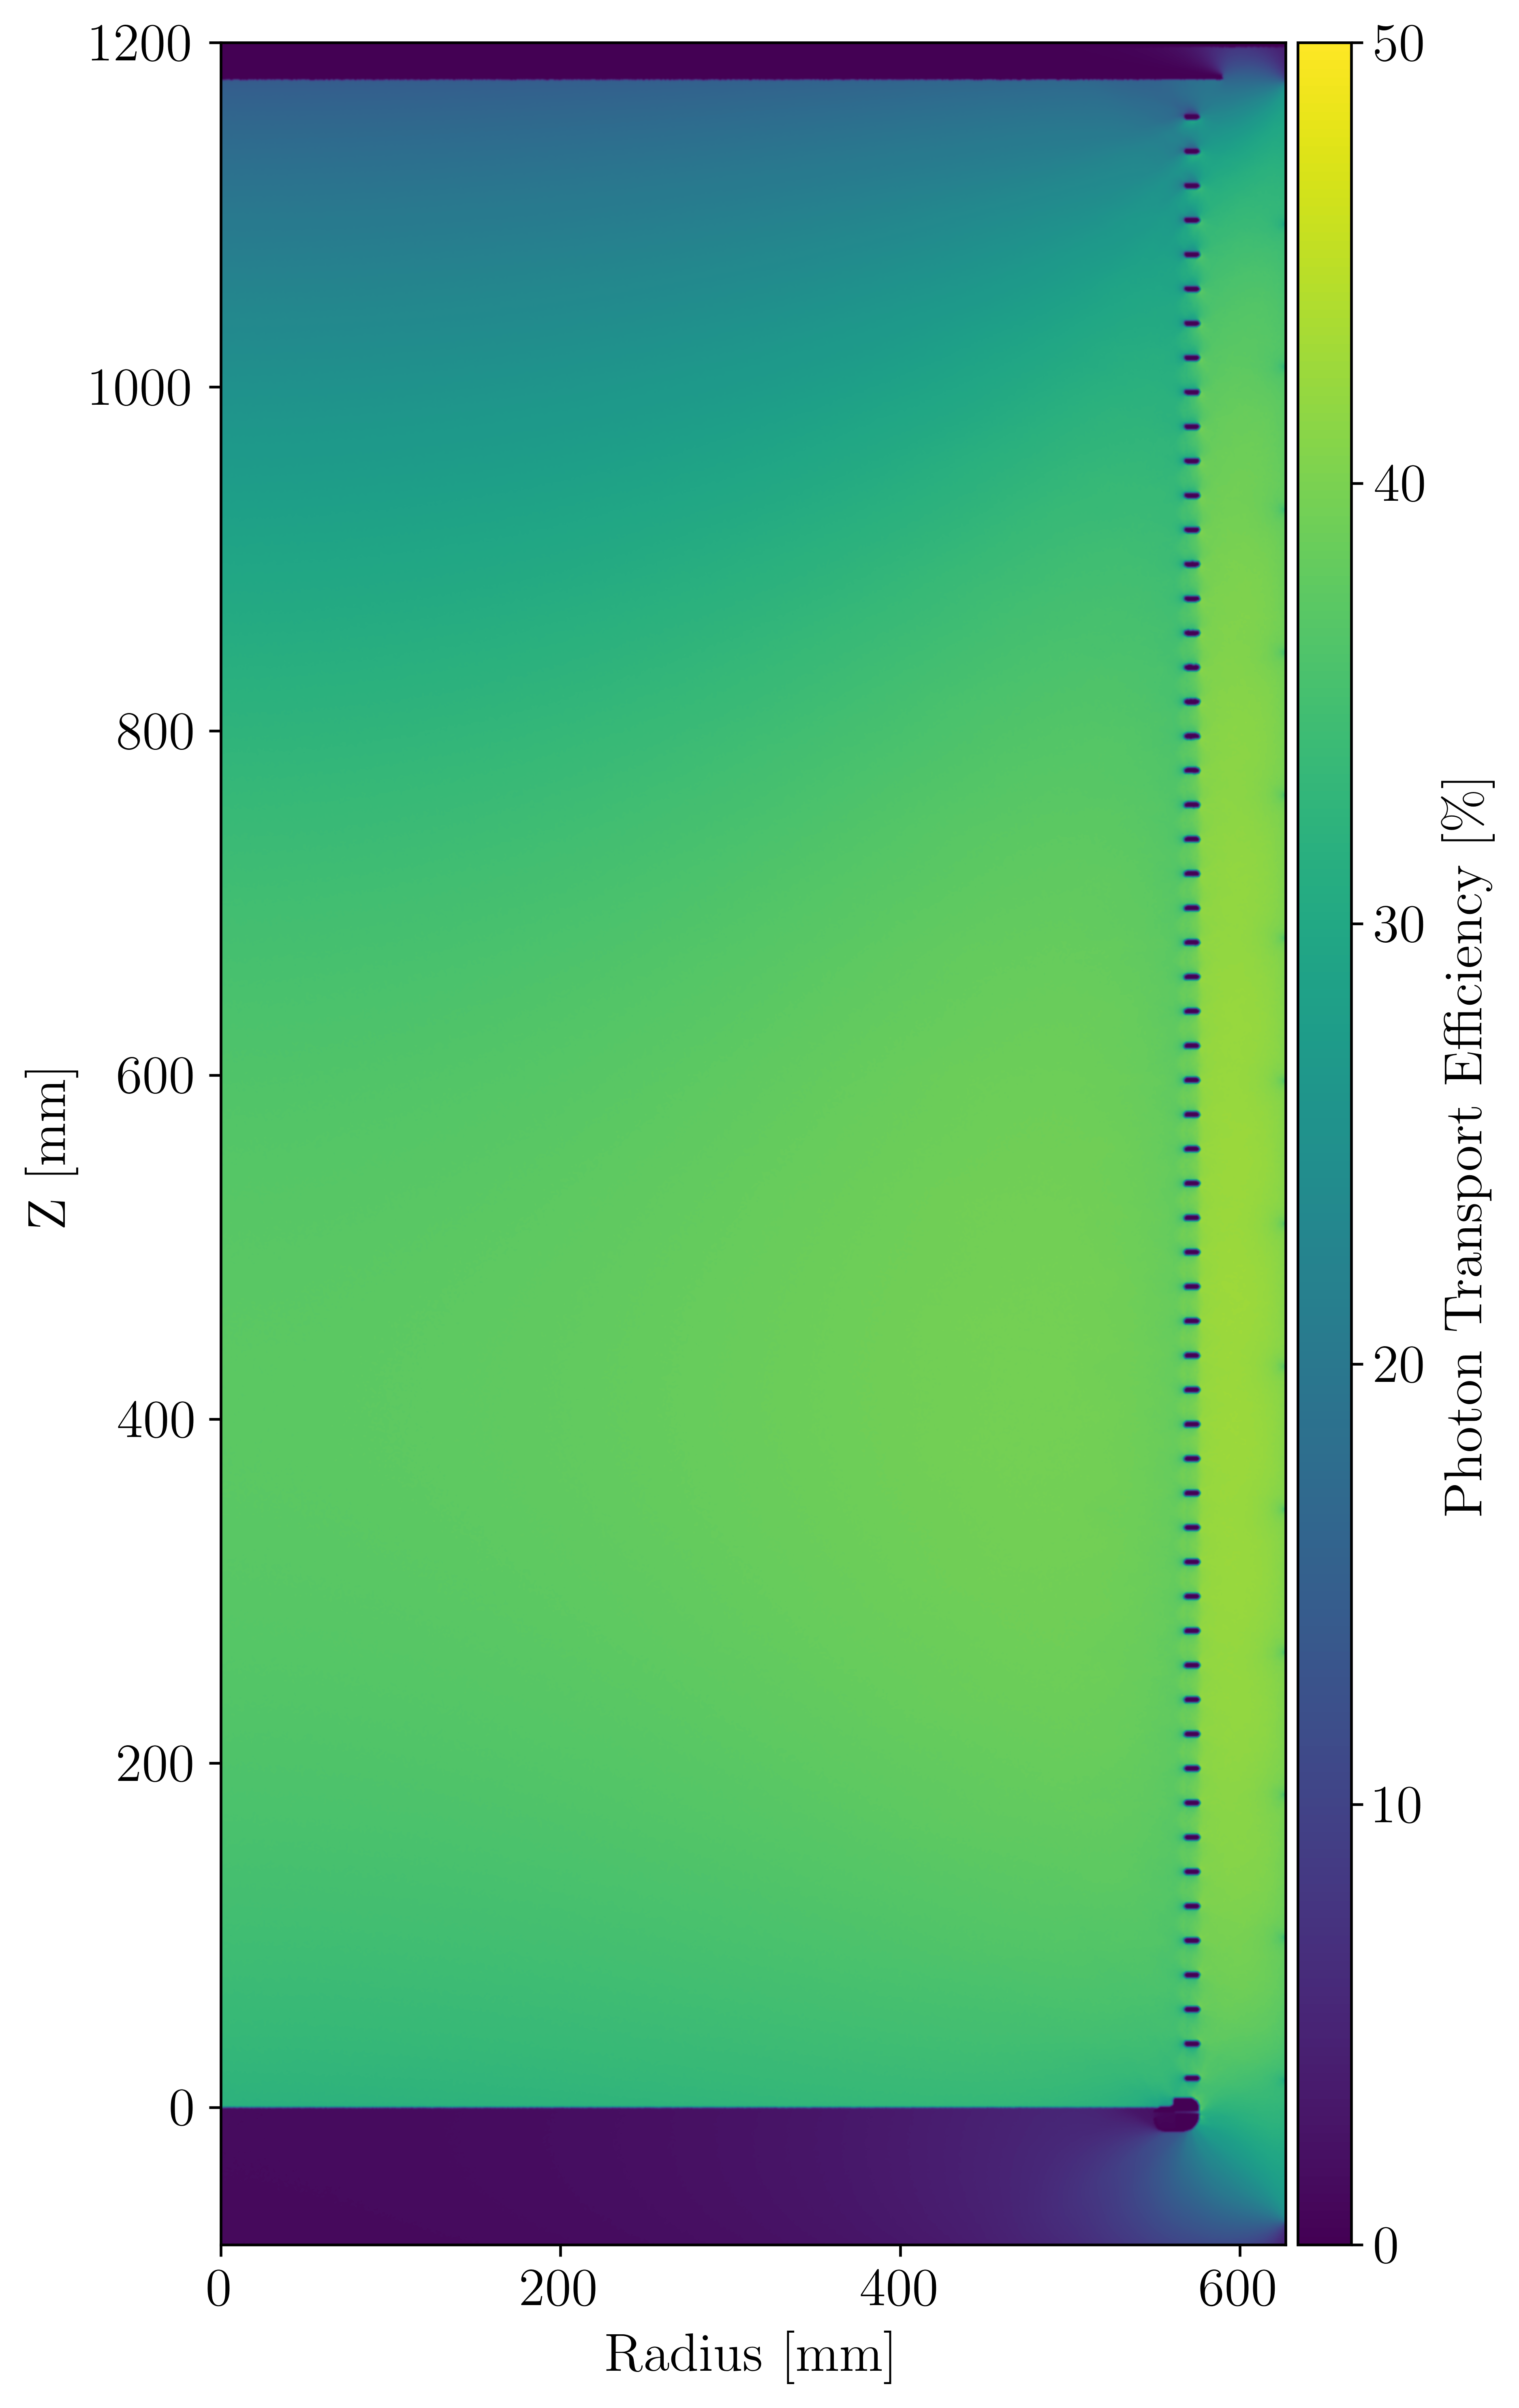

In [5]:
fig, ax = plt.subplots(figsize=(6, 12))    

plt.xlabel('Radius [mm]')
plt.ylabel('Z [mm]')

plt.xlim(0, maxR)
plt.ylim(minZ, maxZ)

im = plt.imshow(Hist, origin='lower', aspect='auto', extent=[minR, maxR, minZ, maxZ], cmap='viridis')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im, cax=cax, orientation='vertical')
cb.ax.tick_params(labelsize=16)
cb.set_label(label=r'Photon Transport Efficiency [$\%$]', fontsize=16)
im.set_clim(vmin=0.0, vmax=50.0)

plt.savefig('lightmap.png')
plt.show()